# IGP 5 Models

## Model


In [29]:
# load functions in python file with magic command
%run ../code/model.py


**Baseline Models**

* Logistic Regression
* Decision Tree
* Random Forest
* Gradient Boosting
* SVM linear
* SVM rbf
* SVC linear
* Naive Bayes
* KNN
* Neural Network
* XGBoost
* LightGBM
* AdaBooast
* QDA



<img src="../_images/process.png" width="400">


#### Metrics

* metric selection and reason
  * `accuracy` - prop of correct predictions; good overall performanced indicator
  * `recall (sensitivity)` - prop of actual positives that are correctly identified.  ability to identify all actual cases of depression.  crucial to minimise false negatives that is failing to identify individuals who are depressed.
  * `precision` - prop of predicted depression which are correct (true positive predictions among all positive predictions) - important when need to avoid false positives (unnecessary concern, intervention, medication, treatment)
   * `F1` - harmonic mean of precision and recall - balance between the two, especially if imbalanced class distribution
   * `specificity` - ability to identify non-depression correctly - important to ensure healthy individuals are not misclassified -  measures the proportion of actual negatives that are correctly identified by the mode
  * `MCC` - takes into account true adn false positives and negatives.  reliable statistic rate that produces a high score only if the prediction obtained good results in all four matrix categories
  * `ROC-AUC - Area Under the Receiver Operating Characteristic Curve`: Evaluates the model’s ability to discriminate between the classes. A higher AUC indicates better model performance.   ROC-AUC is suitable for depression prediction when you want to evaluate the model's ability to distinguish between depressed and non-depressed individuals across different threshold settings.
  * `training time`

Considering `accuracy`, `F1`, `MCC`

### Male dataset

In [19]:
# read from csv 
male_X_train_scaled = pd.read_csv(output_csv_path + 'male_X_train_scaled.csv')
male_y_train = pd.read_csv(output_csv_path + 'male_y_train.csv').iloc[:, 0]

In [20]:
# evaluate models
male_results = evaluate_models(models1, male_X_train_scaled, male_y_train)

# save male_results dictionary to pickle file
with open(output_csv_path + 'male_results_base.pkl', 'wb') as f:
    pickle.dump(male_results, f)


In [21]:
# open pickle file
with open(output_csv_path + 'male_results_base.pkl', 'rb') as f:
    male_results = pickle.load(f)

In [22]:
print_top_models(male_results, metric='accuracy', top_n=5)
#print_top_models(results, top_n=3)
print_top_models(male_results, metric='mcc', top_n=5)
print_top_models(male_results, metric='f1', top_n=5)
print_top_models(male_results, metric='training_time', top_n=5)
print_top_models(male_results, metric='precision', top_n=5)

Top 5 models for accuracy:
1. Neural Network: 0.9084905660377359
2. SVC linear: 0.9009433962264151
3. SVM linear: 0.8971698113207548
4. QDA: 0.8968795355587809
5. Logistic Regression: 0.8818577648766329

Top 5 models for mcc:
1. Neural Network: 0.8218403430655175
2. QDA: 0.8077504216814168
3. SVC linear: 0.8063205437783816
4. SVM linear: 0.7993992527801382
5. SVM rbf: 0.7736912608345243

Top 5 models for f1:
1. Neural Network: 0.912455235025108
2. QDA: 0.9115885710770204
3. SVC linear: 0.9077700834568164
4. SVM linear: 0.9035772113394159
5. SVM rbf: 0.894435060992438

Top 5 models for training time (fastest to slowest):
1. Naive Bayes: 0.02205805778503418 seconds
2. SVC linear: 0.0243621826171875 seconds
3. Decision Tree: 0.026328563690185547 seconds
4. QDA: 0.03175830841064453 seconds
5. SVM linear: 0.03292956352233887 seconds

Top 5 models for precision:
1. Neural Network: 0.9190011947431301
2. SVC linear: 0.8860213412632767
3. SVM linear: 0.8854059566478922
4. Logistic Regression: 0

#### Model for `male` - Evaluation

`Neural network`, `SVC linear`, `SVM linear`, `SVM rbf`, `QDA`, `Logistic Regression`  are top five models going to next round - feature evaluation.

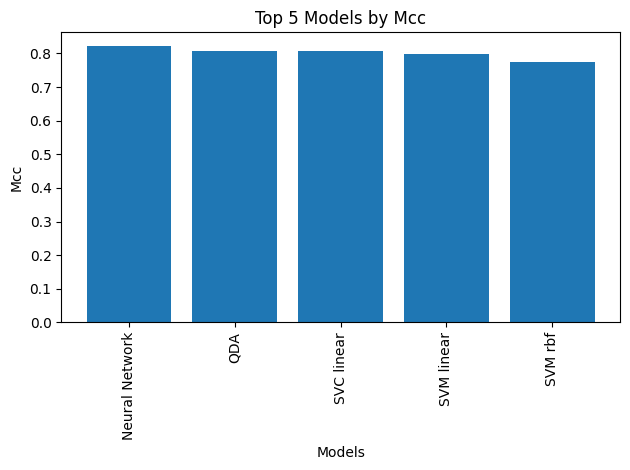

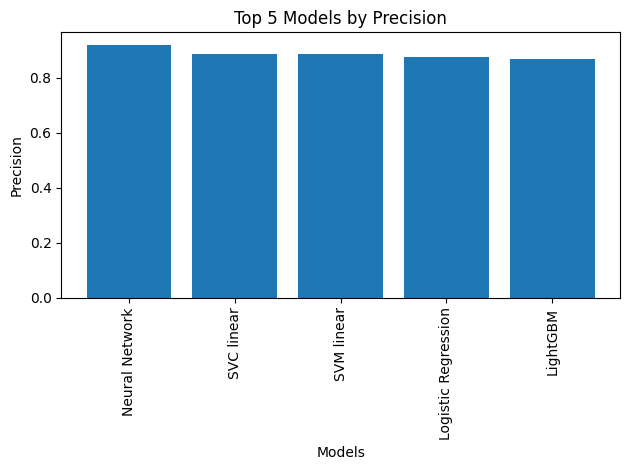

In [23]:
plot_top_models(male_results, metric='mcc', top_n=5)
plot_top_models(male_results, metric='precision', top_n=5)

### Female Dataset

In [24]:
# read from csv
female_X_train_scaled = pd.read_csv(output_csv_path + 'female_X_train_scaled.csv')
female_y_train = pd.read_csv(output_csv_path + 'female_y_train.csv').iloc[:, 0 ]


In [30]:
# evaluate models
female_results = evaluate_models(models1, female_X_train_scaled, female_y_train)

# save female_results dictionary to pickle file
with open(output_csv_path + 'female_results_base.pkl', 'wb') as f:
    pickle.dump(female_results, f)


In [31]:
# open pickle file
with open(output_csv_path + 'female_results_base.pkl', 'rb') as f:
    female_results = pickle.load(f)

In [32]:
print_top_models(female_results, metric='accuracy', top_n=5)
#print_top_models(results, top_n=3)
print_top_models(female_results, metric='mcc', top_n=5)
print_top_models(female_results, metric='f1', top_n=5)
print_top_models(female_results, metric='training_time', top_n=5)
print_top_models(female_results, metric='precision', top_n=5)

Top 5 models for accuracy:
1. Neural Network: 0.9076923076923077
2. Gradient Boosting: 0.8676923076923077
3. SVM rbf: 0.8615384615384615
4. KNN: 0.8553846153846154
5. SVC linear: 0.8523076923076923

Top 5 models for mcc:
1. Neural Network: 0.7964177722054727
2. Gradient Boosting: 0.7067622898143081
3. SVM rbf: 0.6896671534654548
4. KNN: 0.6748030740066342
5. SVC linear: 0.6714532719082419

Top 5 models for f1:
1. Neural Network: 0.8632101819781187
2. Gradient Boosting: 0.8041025937611787
3. KNN: 0.7815218385950093
4. LightGBM: 0.7754749867591121
5. SVC linear: 0.7743969607814002

Top 5 models for training time (fastest to slowest):
1. Naive Bayes: 0.02234935760498047 seconds
2. SVC linear: 0.024544477462768555 seconds
3. QDA: 0.02473611831665039 seconds
4. Decision Tree: 0.030042743682861327 seconds
5. SVM linear: 0.035246992111206056 seconds

Top 5 models for precision:
1. Neural Network: 0.876443942530899
2. SVM rbf: 0.8756344537815126
3. SVC linear: 0.8330952380952381
4. AdaBoost: 0

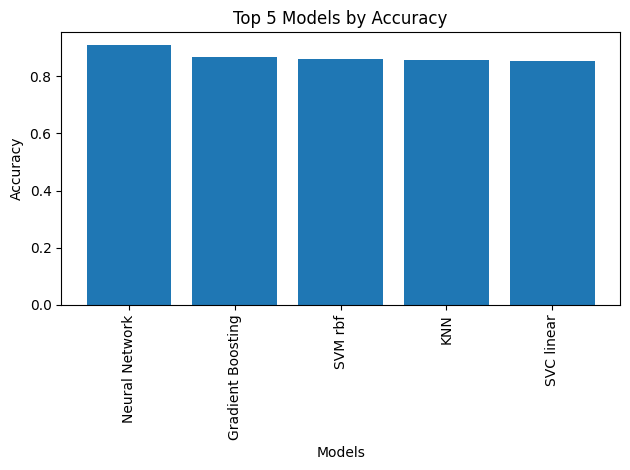

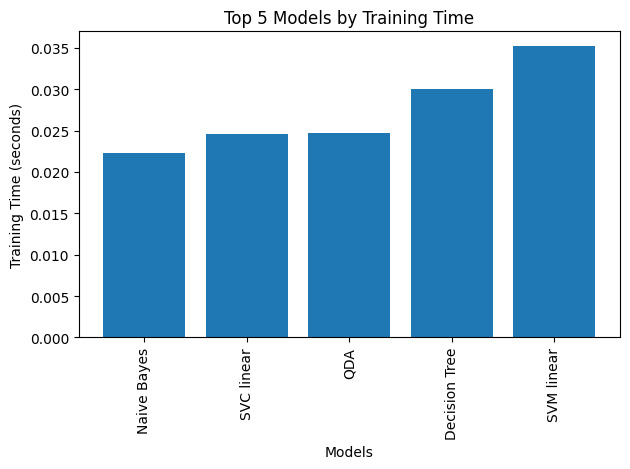

In [33]:
plot_top_models(female_results, metric='accuracy', top_n=5)
plot_top_models(female_results, metric='training_time', top_n=5)

#### Model for `female` - Evaluation

`Neural Network`, `Gradient Boost`, `SVM rbf`, `KNN`, `SVC linear` are top five models going to next round. Also `LightGBM` and `AdaBoost`

### Both Dataset

In [34]:
# read from csv
both_X_train_scaled = pd.read_csv(output_csv_path + 'both_X_train_scaled.csv')
both_y_train = pd.read_csv(output_csv_path + 'both_y_train.csv').iloc[:, 0]

# evaluate models
both_results = evaluate_models(models1, both_X_train_scaled, both_y_train)

# save both_results dictionary to pickle file
with open(output_csv_path + 'both_results_base.pkl', 'wb') as f:
    pickle.dump(both_results, f)

In [35]:
# open pickle file
with open(output_csv_path + 'both_results_base.pkl', 'rb') as f:
    both_results = pickle.load(f)

In [38]:
print_top_models(both_results, metric='accuracy', top_n=5)
#print_top_models(results, top_n=3)
print_top_models(both_results, metric='mcc', top_n=5)
print_top_models(both_results, metric='f1', top_n=5)
print_top_models(both_results, metric='training_time', top_n=5)
print_top_models(both_results, metric='precision', top_n=5)

Top 5 models for accuracy:
1. Neural Network: 0.9048529624800811
2. XGBoost: 0.882833550630161
3. Logistic Regression: 0.8760249167028826
4. SVM linear: 0.8743300014486455
5. SVC linear: 0.8709111980298421

Top 5 models for mcc:
1. Neural Network: 0.8050511104003784
2. XGBoost: 0.7611264395436622
3. Logistic Regression: 0.7460339567358472
4. SVM linear: 0.7429219599214648
5. SVC linear: 0.7362324576357069

Top 5 models for f1:
1. Neural Network: 0.8855767147564046
2. XGBoost: 0.8553700975923674
3. Logistic Regression: 0.8499155059966025
4. SVM linear: 0.8490941421146134
5. SVC linear: 0.8442572145759467

Top 5 models for training time (fastest to slowest):
1. QDA: 0.025513887405395508 seconds
2. Naive Bayes: 0.032451438903808597 seconds
3. SVC linear: 0.03709335327148437 seconds
4. Decision Tree: 0.03840794563293457 seconds
5. Logistic Regression: 0.043346595764160153 seconds

Top 5 models for precision:
1. Neural Network: 0.8942221993692583
2. Gradient Boosting: 0.8911171009284218
3. 

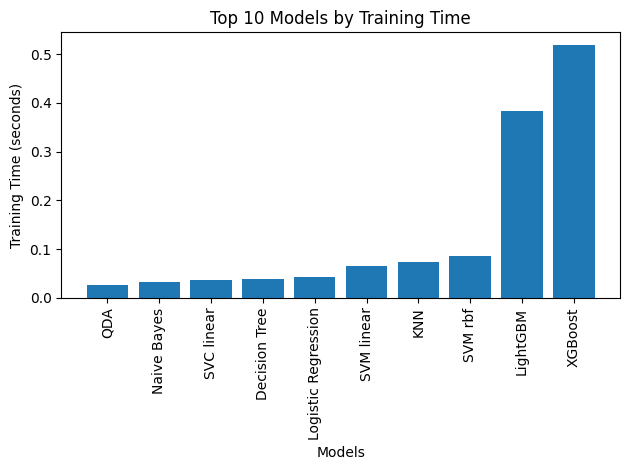

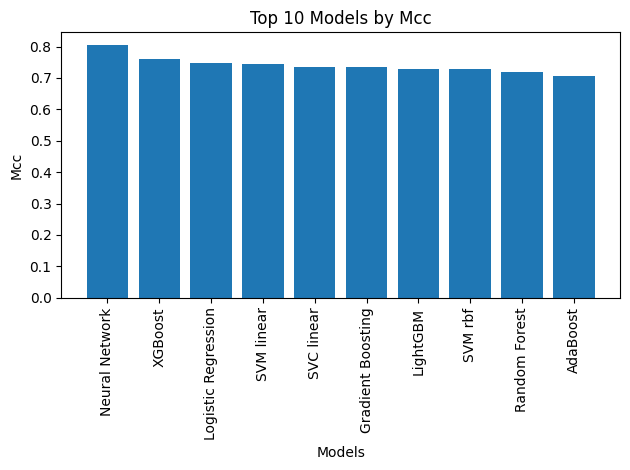

In [37]:
# plot metrics
plot_top_models(both_results, metric='training_time', top_n=10)
plot_top_models(both_results, metric='mcc', top_n=10)



#### Model for `both` - Evaluation

`Neural Network`, `XGBoost`, `Logistic Regression`, `SVM linear`, `SVC linear` are top five models going to next round.